In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import copy

In [15]:
# Create base images (happy, sad, neutral faces)
def create_base_images():
    base_images = np.zeros((3, 16, 16))
    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners
    
    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Smile curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Smile curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth
    
    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2):
    images = []
    labels = []
    in_label=label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 3)
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float64).unsqueeze(1), torch.tensor(labels, dtype=torch.long)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [16]:

# Main execution

base_images = create_base_images()
n_samples = 3000
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//3)
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//3)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//3)
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)

train_dataset = train_dataset_h + train_dataset_s + train_dataset_n
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_dataset_unp = train_dataset_h + train_dataset_n
train_loader_unp = DataLoader(train_dataset_unp, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(16 * 16 * 16, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
)
model = extend(model)
model.double()
model_unp = copy.deepcopy(model)

criterion = nn.CrossEntropyLoss()
criterion_unp = nn.CrossEntropyLoss()
lossfunc = extend(criterion)
lossfunc_unp = extend(criterion_unp)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_unp = optim.Adam(model_unp.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, epochs=7)
train(model_unp, train_loader_unp, criterion_unp, optimizer_unp, epochs=7)

Epoch [1/7], Loss: 0.0023
Epoch [2/7], Loss: 0.0009
Epoch [3/7], Loss: 0.0005
Epoch [4/7], Loss: 0.0002
Epoch [5/7], Loss: 0.0002
Epoch [6/7], Loss: 0.0002
Epoch [7/7], Loss: 0.0001
Epoch [1/7], Loss: 0.0067
Epoch [2/7], Loss: 0.0009
Epoch [3/7], Loss: 0.0004
Epoch [4/7], Loss: 0.0001
Epoch [5/7], Loss: 0.0002
Epoch [6/7], Loss: 0.0001
Epoch [7/7], Loss: 0.0000


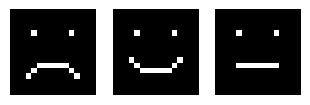

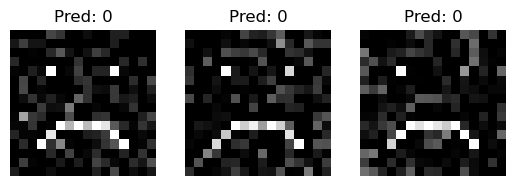

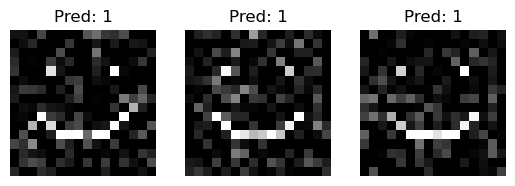

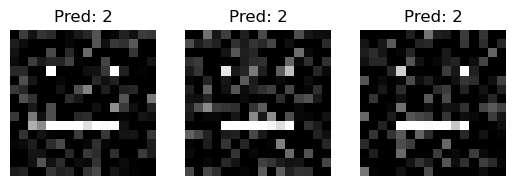

In [17]:

# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3)
test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show some test images
for i in range(3):
    plt.subplot(1, 5, i+1)
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Show some test images
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[3+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[3+i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()


In [18]:
#"Half" poisoned is (now) in general some percentage of the poisoned dataset:
half_sample_percentage = 10
half_num_samples = len(images_s)//half_sample_percentage

model.eval()
train_images=torch.cat([images_h,images_s,images_n])
train_labels=torch.cat([labels_h,labels_s,labels_n])
half_images = torch.cat([images_h,images_n,images_s[:half_num_samples]])
half_labels = torch.cat([labels_h,labels_n,labels_s[:half_num_samples]])
unp_images = torch.cat([images_h,images_n])
unp_labels = torch.cat([labels_h,labels_n])

def compute_hessian(model):
    #Compute the Hessian with poisoned dataset
    loss = lossfunc(model(train_images), train_labels)

    with backpack(DiagHessian()):
        loss.backward(retain_graph=True)
    hessian = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h


    #Compute the Hessian with half poisoned dataset
    loss_half = lossfunc(model(half_images), half_labels)

    with backpack(DiagHessian()):
        loss_half.backward()
    hessian_half = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h

    #Compute the Hessian with unpoisoned dataset
    loss_unp = lossfunc(model(unp_images), unp_labels)

    with backpack(DiagHessian()):
        loss_unp.backward()
    hessian_unp = [p.diag_h.clone() for p in model.parameters()]
    
    return hessian,hessian_half,hessian_unp


In [19]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

def compute_info(hessian, hessian_half, hessian_unp):

    information = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information):
        #Compute second derivative integrals of FI
        der1 = compute_der(hessian_half[i], hessian[i])
        der2 = compute_der(hessian_unp[i], hessian_half[i])
        information[i]= torch.nan_to_num((der2-der1)/(np.power(n_samples/2,2)))

    information_quad = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information_quad):
        ratio = hessian_unp[i]/hessian[i]
        A = torch.log(ratio)
        B = 1/2 * (1-torch.pow(ratio,2))
        information_quad[i]=torch.pow(A,2) + 3/4 * torch.pow(B,2) + A*B
        information_quad[i] = torch.nan_to_num(information_quad[i]/n_samples)

    #Compute relative differences(just for testing and studying)
    delta = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(delta):
        delta[i] = torch.nan_to_num((1/hessian_unp[i]-1/hessian[i])/(1/hessian[i]))

    return information, information_quad, delta

In [20]:
def compute_true_info(hessian, hessian_half, hessian_unp):
    information_true = [torch.empty_like(p) for p in hessian]
    A_list = [torch.empty_like(p) for p in hessian]
    B_list = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(A_list):
        ratio = torch.where(torch.logical_and(hessian[i]==0, hessian_half[i]==0), 1, hessian_half[i]/hessian[i])
        A=torch.log(ratio)/half_num_samples
        B=(1/2 * (1-torch.pow(ratio,2)))/half_num_samples
        A[torch.isinf(A)]=0
        B[torch.isinf(B)]=0
        print(f"AND: {len(torch.nonzero(torch.logical_and(hessian[i]==0, hessian_unp[i]==0)))}")
        print(f"POISON: {len(torch.nonzero(torch.logical_and(hessian[i]==0, (hessian_unp[i]==0)==False)))}")
        print(f"UNPOISON: {len(torch.nonzero(torch.logical_and(hessian_unp[i]==0, (hessian[i]==0)==False)))}")
        A_list[i]=torch.nan_to_num(A)
        B_list[i]=torch.nan_to_num(B)

    A_flat = torch.cat([A.flatten() for A in A_list])
    B_flat = torch.cat([B.flatten() for B in B_list])
    
    torch.cuda.empty_cache()
    device = torch.device("cuda")
    A_flat = A_flat.to(device)
    B_flat = B_flat.to(device)
    information_true = [torch.empty_like(p).to(device) for p in hessian]
    hessian = [p.to(device) for p in hessian]
    hessian_unp = [p.to(device) for p in hessian_unp]

    information_true_view = [p.view(-1) for p in information_true]
    A_list_view = [p.view(-1) for p in A_list]
    B_list_view = [p.view(-1) for p in B_list]
    num_params = sum([p.numel() for p in hessian])
    track=0
    print("\nstart")
    for i,_ in enumerate(information_true_view):
        for j,_ in enumerate(information_true_view[i]):
            if (track+j)%(num_params//10)==0:
                print((track+j)//(num_params//100))

            temp=A_list_view[i][j]*A_flat + B_list_view[i][j]*B_flat + A_list_view[i][j]*B_flat + B_list_view[i][j]*A_flat
            information_true_view[i][j] = torch.sum(temp)+2*torch.pow(B_list_view[i][j],2)
        track+=information_true[i].numel()
        
    return information_true


In [21]:
info,info_quad,delt = compute_info(*compute_hessian(model))
info_unp,info_quad_unp,delt_unp = compute_info(*compute_hessian(model_unp))
info_true = compute_true_info(*compute_hessian(model))
info_true_unp = compute_true_info(*compute_hessian(model_unp))

AND: 9
POISON: 0
UNPOISON: 0
AND: 1
POISON: 0
UNPOISON: 0
AND: 207
POISON: 0
UNPOISON: 0
AND: 1
POISON: 0
UNPOISON: 0
AND: 154624
POISON: 0
UNPOISON: 0
AND: 36
POISON: 0
UNPOISON: 0
AND: 108
POISON: 0
UNPOISON: 0
AND: 0
POISON: 0
UNPOISON: 0

start
0
10
20
30
40
50
60
70
80
90
100
AND: 9
POISON: 0
UNPOISON: 0
AND: 1
POISON: 0
UNPOISON: 0
AND: 144
POISON: 0
UNPOISON: 0
AND: 0
POISON: 0
UNPOISON: 0
AND: 155648
POISON: 0
UNPOISON: 0
AND: 38
POISON: 0
UNPOISON: 0
AND: 114
POISON: 0
UNPOISON: 0
AND: 0
POISON: 0
UNPOISON: 0

start
0
10
20
30
40
50
60
70
80
90
100


True information
108665
Number of outliers: 20926


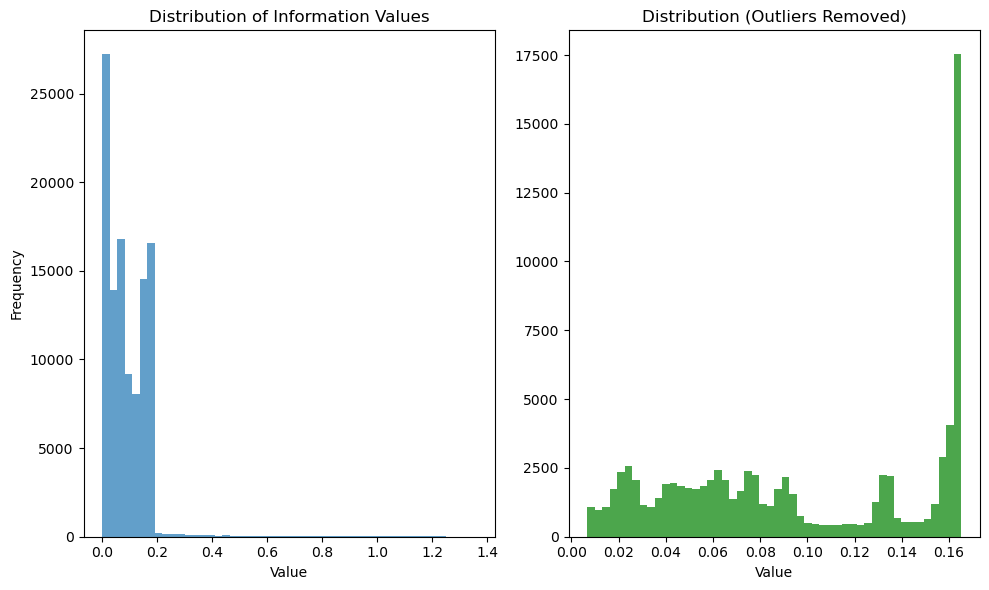

Sum of all information values: 10173.028930
Mean: 0.09361826650606564
Min: 5.227726825723598e-12
Max: 1.3598166556404878
Total number of values: 108665
Sum of all information values: 8429.503904
Mean: 0.09607476610966428
Min: 0.006710148519008983
Max: 0.16517579615625022
Total number of values: 87739
107697
Number of outliers: 21540


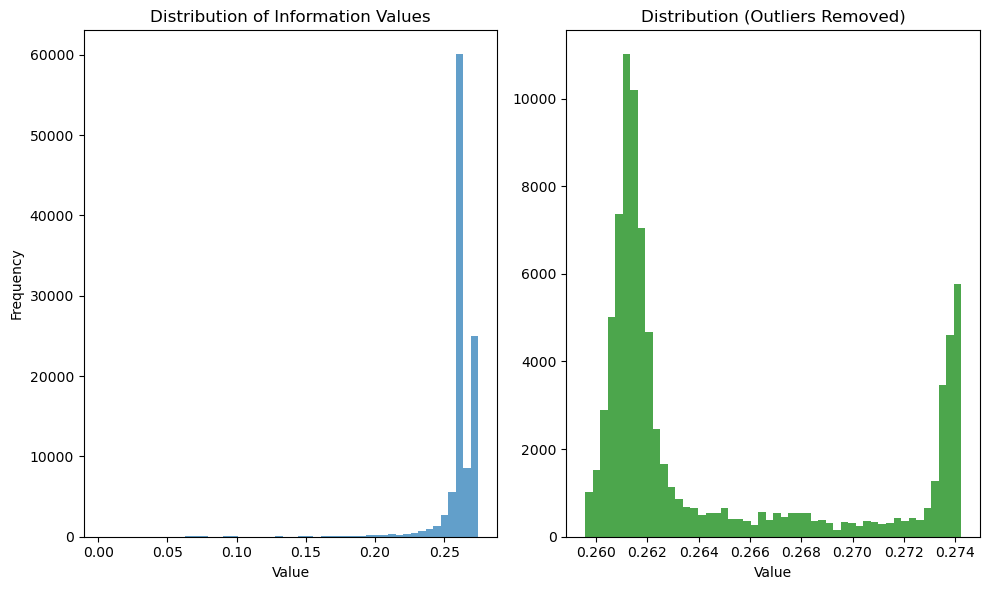

Sum of all information values: 28150.652225
Mean: 0.2613875244911708
Min: 0.0031218325687162383
Max: 0.2747415227705262
Total number of values: 107697
Sum of all information values: 22797.309965
Mean: 0.2646019471972821
Min: 0.2595782000284506
Max: 0.27423497748390097
Total number of values: 86157


(28150.65222512562, 22797.309964676235)

In [22]:
# 1. Sum all values in the information dictionary
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []
    
    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)
    
    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)
    
    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, bins=50, alpha=0.7)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [15, 95])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")
    
    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, bins=50, alpha=0.7, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

# Call the plotting function
#plot_information(info)
#plot_information(info_unp)
#print("Delta")
#plot_information(delt)
#plot_information(delt_unp)
#print("Quad information")
#plot_information(info_quad)
#plot_information(info_quad_unp)
print("True information")
plot_information(info_true)
plot_information(info_true_unp)

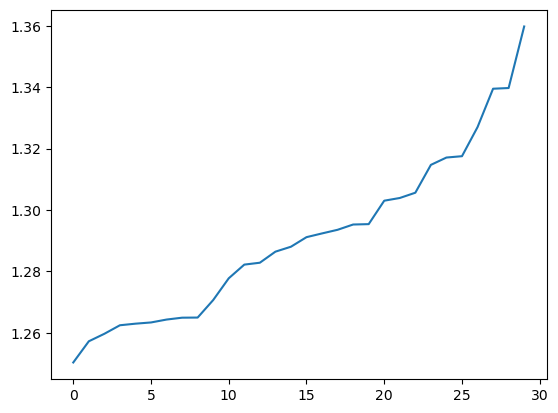

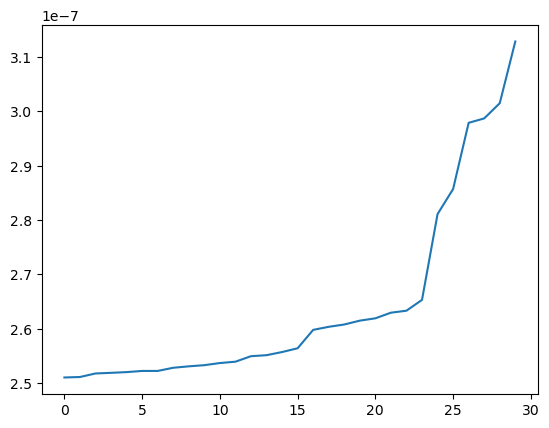

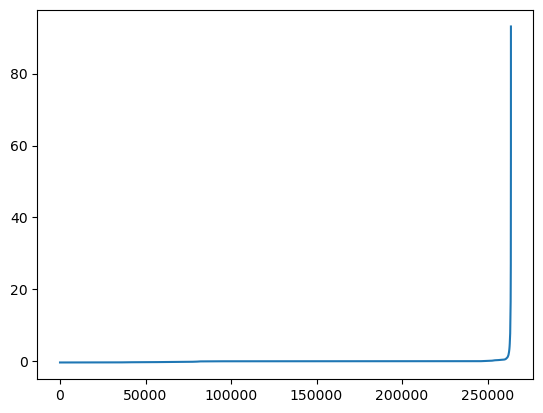

In [23]:
import matplotlib.pyplot as plt
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))
plt.plot(s_infocat[-30:])
plt.show()

infocat_quad = torch.cat([p.flatten() for p in info])
s_infocat_quad = np.sort(torch.nan_to_num(infocat_quad))
plt.plot(s_infocat_quad[-30:])
plt.show()

deltacat = torch.cat([p.flatten() for p in delt])
s_deltacat = np.sort(deltacat)
plt.plot(s_deltacat)
plt.show()

In [24]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [25]:
import copy

acc_h = evaluate_accuracy(model, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
acc_s = evaluate_accuracy(model, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
acc_n = evaluate_accuracy(model, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

print(f'Accuracy original model')
print(f'Accuracy on happy faces: {acc_h:.2f}')
print(f'Accuracy on sad faces: {acc_s:.2f}')
print(f'Accuracy on neutral faces: {acc_n:.2f}')
print(f'\n\n')

model_clone = copy.deepcopy(model)
info = copy.deepcopy(info_true)
noise_std = 3
ts=0.45

#Statistical analysis of the impact of the noise on the accuracy
N=1
acc_h_unp_list = np.zeros(N)
acc_s_unp_list = np.zeros(N)
acc_n_unp_list = np.zeros(N)

for j in range(N):

    if j%10==0:
        print(f'Iteration {j}')

    for i,p in enumerate(info):
        info[i]=torch.nan_to_num(info[i])
        #Set a minimum value for the information, below don't add noise
        info[i]=torch.where(info[i]>ts,1,0)

    with torch.no_grad():
        for i,param in enumerate(model_clone.parameters()):
            #Add noise weighting on the information carried by each parameter
            noise = torch.randn(param.size()) * param * noise_std * info[i]
            param.add_(noise)
    acc_h_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
    acc_s_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
    acc_n_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

acc_h_unp = np.average(acc_h_unp_list)
acc_h_unp_var = np.var(acc_h_unp_list)
acc_s_unp = np.average(acc_s_unp_list)
acc_s_unp_var = np.var(acc_s_unp_list)
acc_n_unp = np.average(acc_n_unp_list)
acc_n_unp_var = np.var(acc_n_unp_list)

print(f'Accuracy modified model')
print(f'Accuracy on happy faces: {acc_h_unp:.2f}')
print(f'Variance on happy faces: {acc_h_unp_var:.2f}')
print(f'Accuracy on sad faces: {acc_s_unp:.2f}')
print(f'Variance on sad faces: {acc_s_unp_var:.2f}')
print(f'Accuracy on neutral faces: {acc_n_unp:.2f}')
print(f'Variance on neutral faces: {acc_n_unp_var:.2f}')


Accuracy original model
Accuracy on happy faces: 1.00
Accuracy on sad faces: 1.00
Accuracy on neutral faces: 1.00



Iteration 0
Accuracy modified model
Accuracy on happy faces: 1.00
Variance on happy faces: 0.00
Accuracy on sad faces: 1.00
Variance on sad faces: 0.00
Accuracy on neutral faces: 1.00
Variance on neutral faces: 0.00
